## 0. Importing Libraries

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

import pandas as pd
assert pd.__version__ >= "1.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

## 1. Loading Data

In [27]:
features, target = load_svmlight_file('diabetes.txt')

features = features.toarray()
pd.DataFrame(features).describe()

,0,1,2,3,4,5,6,7
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.547641,0.215020,0.132877,-0.585122,-0.811349,-0.046421,-0.663641,-0.591971
std,0.396421,0.321333,0.317308,0.322267,0.272444,0.234997,0.282945,0.392008
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858455,-0.900000
50%,-0.647059,0.175879,0.180328,-0.535354,-0.927896,-0.046200,-0.748506,-0.733333
75%,-0.294118,0.409547,0.311475,-0.353535,-0.699173,0.090909,-0.531811,-0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.Exploratory data analysis

In [28]:
# split the dataset
X_bigtrain, X_test, y_bigtrain, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_bigtrain, y_bigtrain , test_size=0.2, random_state=42, stratify=y_bigtrain)

print(f'Shapes of sets are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes of sets are [(491, 8), (491,), (154, 8), (154,), (123, 8), (123,)]


In [4]:
## EDA 
colnames=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','label']

df = pd.DataFrame(features)
df['Outcome']=target

df.columns=colnames

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,label
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0


In [5]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
def hist_plot(features, Nrows, Ncols):

    fig, axes = plt.subplots(Nrows, Ncols, figsize=(20, 20))

    for row in range(Nrows):
        for col in range(Ncols):
            feature = features[row * Ncols + col]
            sns.histplot(data=df, x=feature, hue="label", bins='auto', kde=True, ax=axes[row,col], edgecolor=None)
            # sns.boxplot(y=feature,x='label',data=df, ax=axes[row,col])

    plt.show()   

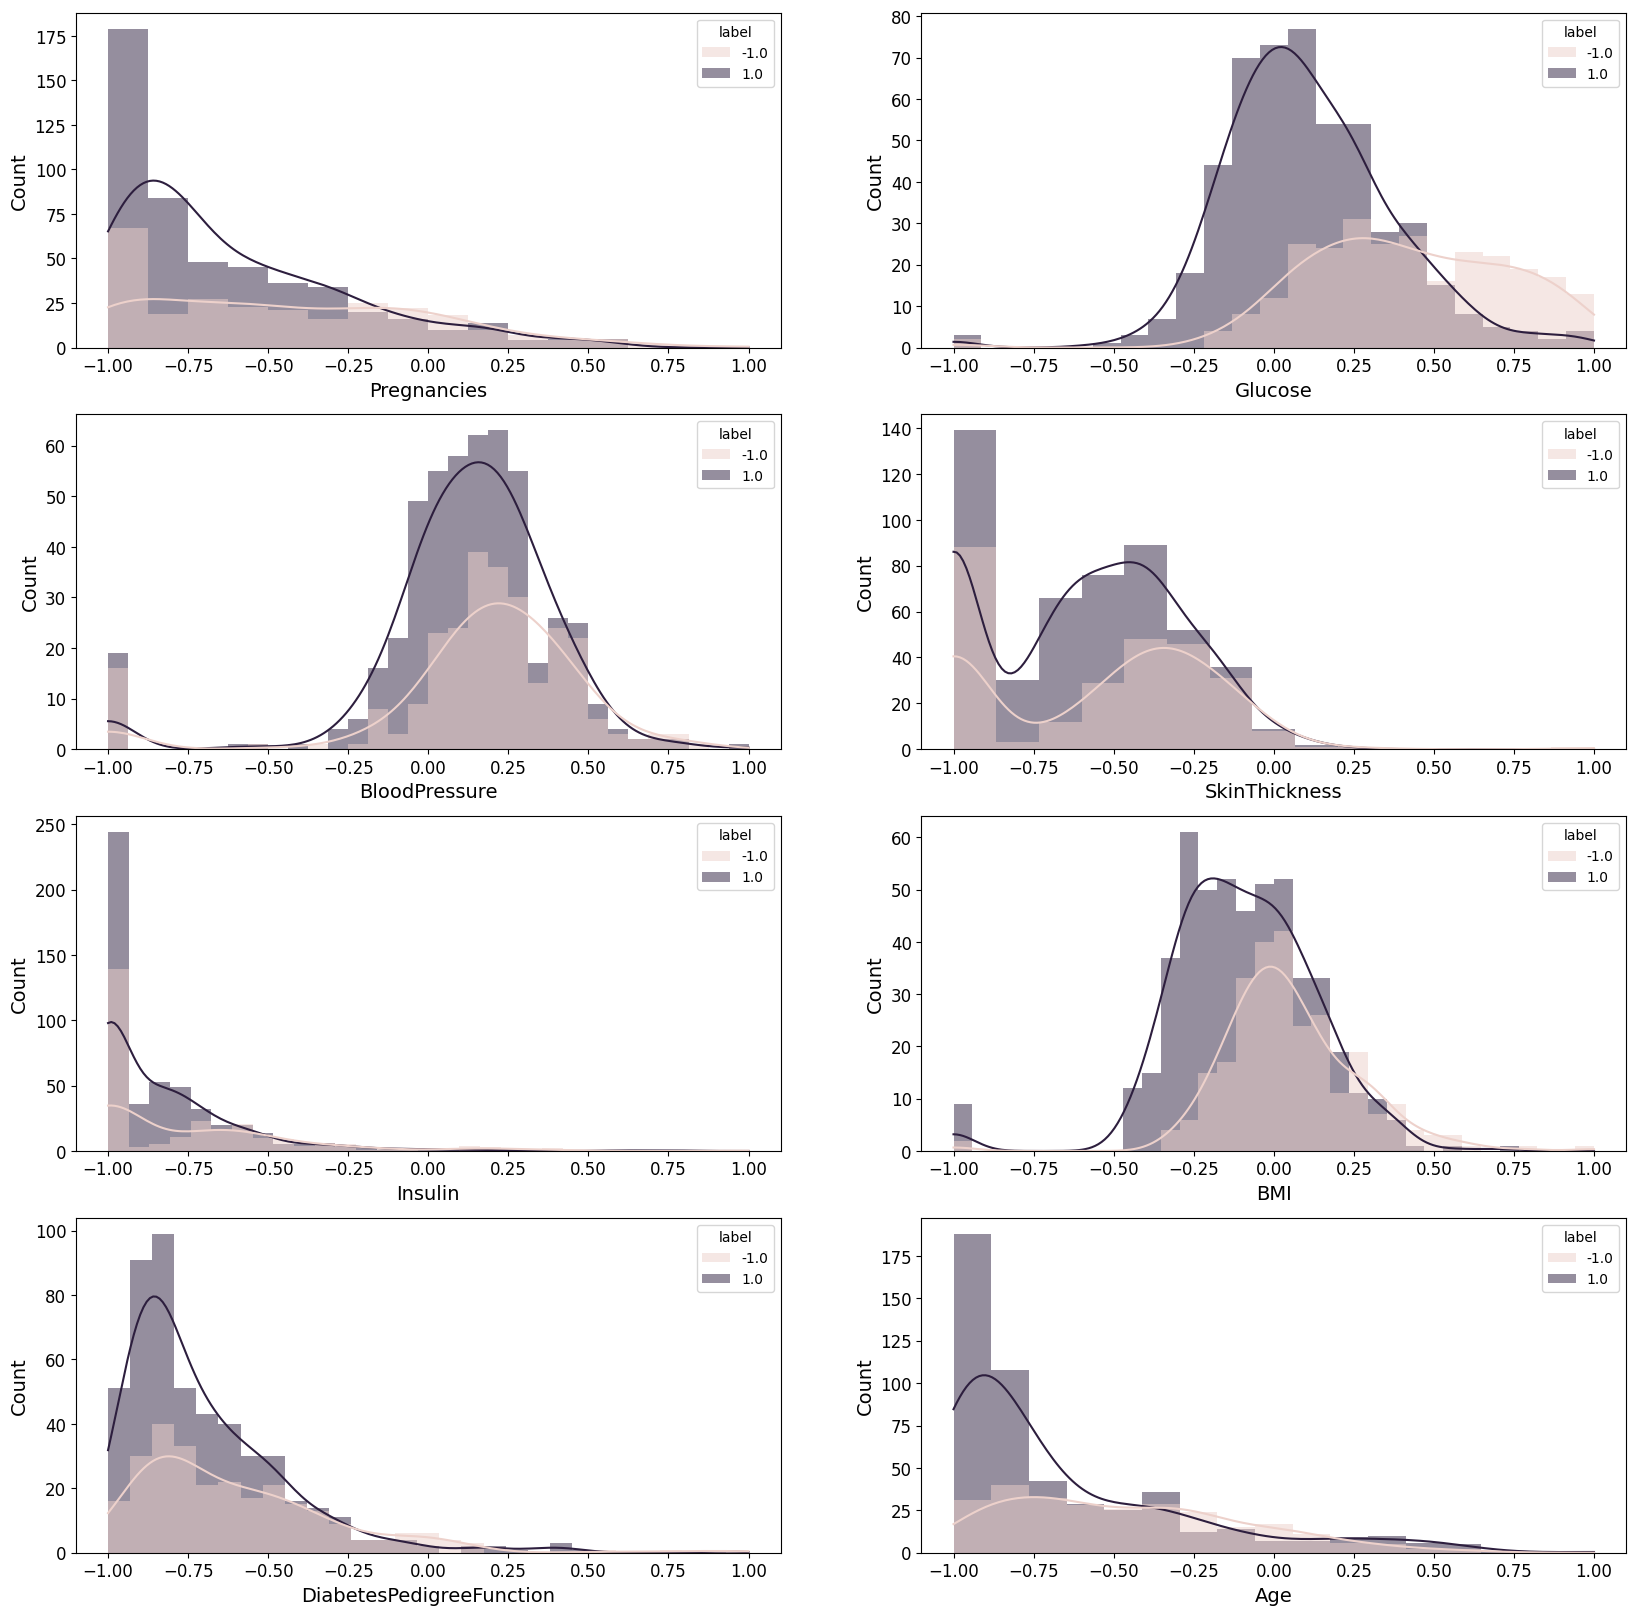

In [6]:
hist_plot(colnames,4,2)

## 3.Model Implement

In [7]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

comparison_model = Perceptron(eta0=0.01, max_iter=20)


# Train model (20 epochs)
fitted_model = comparison_model.fit(X_train,
                                    y_train.reshape((y_train.shape[0],)))
predictions = fitted_model.predict(X_val)

print("Validation accuracy = ", accuracy_score(y_val, predictions))

Validation accuracy =  0.7642276422764228


## Perceptron Implementation

In [31]:
class Perceptron:
    def __init__(self, X_train, y_train, X_val, y_val, lr = 1,
                 bias = False, seed = -1, randomBias = False,
                 loss="zero_one", earlyStoppingPatience = -1):
        self.X_train = X_train
        self.y_train = y_train.reshape(y_train.shape[0], 1)
        self.X_val = X_val
        self.y_val = y_val
        self.bias = bias
        self.trainingAccuracies = []
        self.validationAccuracies = []
        self.weightVectors = []
        self.trainingLosses = []
        self.validationLosses = []
        self.testLosses = []
        self.seed = seed
        self.currentBestValAccuracy = 0
        self.currentBestIndex = 0
        self.randomBias = randomBias
        self.loss = loss
        self.earlyStoppingPatience = earlyStoppingPatience
        self.originalEarlyStoppingPatience = self.earlyStoppingPatience
        self.predictions = np.array([])
        
        self.lr = lr
        self.weights = self.initializeWeights()

        
    def __addBiasColumn(self):
        onesTrain = np.ones(self.X_train.shape[0]).reshape((self.X_train.shape[0], 1))
        onesVal = np.ones(self.X_val.shape[0]).reshape((self.X_val.shape[0], 1))
        self.X_train = np.append(onesTrain, self.X_train, axis=1)
        self.X_val = np.append(onesVal, self.X_val, axis=1)
        
    def __addBiasColumnToTest(self, X):
        X_temp = X.copy()
        onesTest = np.ones(X_temp.shape[0]).reshape((X_temp.shape[0], 1))
        return np.append(onesTest, X_temp, axis=1)
        
    def initializeWeights(self):
        # Set random seed if seed is greated than or equal to 0.
        if self.seed >= 0:
            np.random.seed(self.seed)
            
        weightVectorLength = self.X_train.shape[1]
        weights = np.array([])
        
        # Add bias if needed.
        if self.bias:
            self.__addBiasColumn()
            weightVectorLength += 1
            if not self.randomBias:
                weights = np.array([1])
                weights = np.append(weights, np.random.rand(weightVectorLength - 1)).reshape((weightVectorLength, 1))
            else:
                weights = np.random.rand(weightVectorLength).reshape((weightVectorLength, 1))
        else:
            weights = np.random.rand(weightVectorLength).reshape((weightVectorLength, 1))
                
        return weights
    
    def train(self, epochs = 10, verbose = True, showPlots = True):
        self.currentBestValAccuracy = 0
        for i in range(epochs):
            # Perform W.X + b
            multiplicationRes = self.X_train @ self.weights
            
            # Create weight updating decision function
            yMultiplicationRes = np.multiply(self.y_train, multiplicationRes)
            
            # Handle 3 types of losses (zero-one, perceptron, hinge (svm))
            if self.loss == "zero_one":
                yMultiplicationRes[yMultiplicationRes >= 0] = 0
                yMultiplicationRes[yMultiplicationRes < 0] = 1
            elif self.loss == "perceptron":
                yMultiplicationRes[yMultiplicationRes >= 0] = 0
                yMultiplicationRes[yMultiplicationRes < 0] = -yMultiplicationRes[yMultiplicationRes < 0]
            else:
                yMultiplicationRes[yMultiplicationRes <= 1] = 1 - yMultiplicationRes[yMultiplicationRes <= 1]
                yMultiplicationRes[yMultiplicationRes > 1] = 0
            
            # YX
            yTimesX = np.multiply(self.y_train, self.X_train)
            result = np.sum(np.multiply(yTimesX, yMultiplicationRes), axis = 0)
            result = (result.reshape((result.shape[0], 1))) * self.lr

            # Update weights
            self.weights = np.add(self.weights, result)
            
            # Keep track of weights
            self.weightVectors.append(self.weights)
            
            # Store loss value
            self.__storeValLossAndAccuracy()
            self.__storeTrainLossAndAccuracy()
            
            # Display epoch by epoch results
            if verbose:
                print("Epoch {}:".format(i + 1))
                print("Training Acc:", self.trainingAccuracies[i])
                print("Validation Acc:", self.validationAccuracies[i])
                print("Training Loss:", self.trainingLosses[i])
                print("Validation Loss:", self.validationLosses[i], "\n")
                
            if self.earlyStoppingPatience == 0:
                print("Early stopped at epoch", (i + 1))
                break
                
        if showPlots:
            # Plot graphs of loss and accuracy
            plt.title("Loss curves")
            plt.plot(np.arange(0, len(self.trainingLosses)), self.trainingLosses, label="Training loss")
            plt.plot(np.arange(0, len(self.validationLosses)),
                    self.validationLosses, label="Validation loss")
            plt.xlabel("Number of epochs")
            plt.ylabel("Loss")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()
            
            plt.title("Accuracy curves")
            plt.plot(np.arange(0, len(self.trainingAccuracies)),
                    self.trainingAccuracies, label="Training Accuracy")
            plt.plot(np.arange(0, len(self.validationAccuracies)),
                    self.validationAccuracies, label="Validation Accuracy")
            plt.xlabel("Number of epochs")
            plt.ylabel("Accuracy")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()
                
    def __storeValLossAndAccuracy(self):
        losses = np.multiply(self.y_val, self.X_val @ self.weights)
        
        if self.loss == "zero_one":
            losses[losses >= 0] = 0
            losses[losses < 0] = 1
        elif self.loss == "perceptron":
            losses[losses >= 0] = 0
            losses[losses < 0] = -losses[losses < 0]
        else:
            losses[losses <= 1] = 1 - losses[losses <= 1]
            losses[losses > 1] = 0
            
        loss = np.sum(losses, axis = 0)[0] / len(self.y_val)
        self.validationLosses.append(loss)
        
        valAccuracy = self.calc_accuracy(self.y_val, self.predict(self.X_val))
        self.validationAccuracies.append(valAccuracy)
        
        # Store best accuracy
        if valAccuracy >= self.currentBestValAccuracy:
            self.currentBestValAccuracy = valAccuracy
            self.currentBestIndex = len(self.validationAccuracies) - 1
            self.earlyStoppingPatience = self.originalEarlyStoppingPatience
        else:
            self.earlyStoppingPatience -= 1
        
    def __storeTrainLossAndAccuracy(self):
        losses = np.multiply(self.y_train, self.X_train @ self.weights)
        
        if self.loss == "zero_one":
            losses[losses >= 0] = 0
            losses[losses < 0] = 1
        elif self.loss == "perceptron":
            losses[losses >= 0] = 0
            losses[losses < 0] = -losses[losses < 0]
        else:
            losses[losses <= 1] = 1 - losses[losses <= 1]
            losses[losses > 1] = 0
            
        loss = np.sum(losses, axis = 0)[0] / len(self.y_train)
        self.trainingLosses.append(loss)
        self.trainingAccuracies.append(self.calc_accuracy(self.y_train, self.predict(self.X_train)))
            
    def predict(self, X):
        predictions = np.sign(np.matmul(X, self.weights))
        return predictions
    
    def calc_accuracy(self, actual, predictions):
        count = 0
        length = len(actual)
        for i in range(length):
            if actual[i] == predictions[i]:
                count += 1
        return count / length
    
    def evaluate(self, X, y):
        predictions = np.array([])
        if self.bias:
            X_new = self.__addBiasColumnToTest(X)
            predictions = self.predict(X_new)
        else:
            predictions = self.predict(X)
        self.predictions = predictions
        return self.calc_accuracy(y, predictions)
    
    def getBestParameters(self):
        return (self.weightVectors[self.currentBestIndex],
                self.trainingAccuracies[self.currentBestIndex],
                self.validationAccuracies[self.currentBestIndex])
    
    def setBest(self):
        print(self.currentBestIndex)
        self.weights = self.weightVectors[self.currentBestIndex]
        

-----initializeWeights-----
Epoch 1:
Training Acc: 0.6496945010183299
Validation Acc: 0.6504065040650406
Training Loss: 0.35030549898167007
Validation Loss: 0.0 

Epoch 2:
Training Acc: 0.6537678207739308
Validation Acc: 0.6585365853658537
Training Loss: 0.34623217922606925
Validation Loss: 0.008130081300813009 

Epoch 3:
Training Acc: 0.34826883910386963
Validation Acc: 0.34959349593495936
Training Loss: 0.6517311608961304
Validation Loss: 1.0 

Epoch 4:
Training Acc: 0.6496945010183299
Validation Acc: 0.6504065040650406
Training Loss: 0.35030549898167007
Validation Loss: 0.0 

Epoch 5:
Training Acc: 0.659877800407332
Validation Acc: 0.6910569105691057
Training Loss: 0.34012219959266804
Validation Loss: 0.04065040650406504 

Epoch 6:
Training Acc: 0.4256619144602851
Validation Acc: 0.3902439024390244
Training Loss: 0.5743380855397149
Validation Loss: 0.943089430894309 

Epoch 7:
Training Acc: 0.6537678207739308
Validation Acc: 0.6585365853658537
Training Loss: 0.34623217922606925
Vali

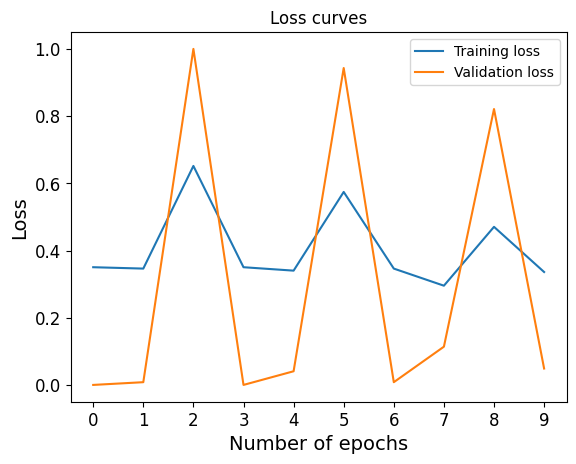

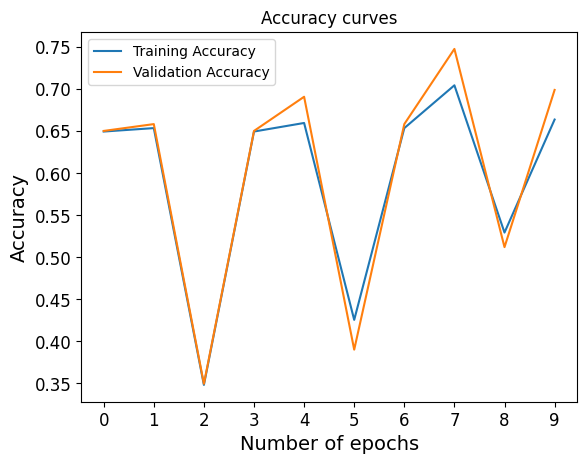

7


In [32]:
# Create a simple perceptron (with 0-1 loss)
perceptron = Perceptron(X_train, y_train, X_val, y_val, lr=0.01, bias=False,
                        seed=200, randomBias=False, earlyStoppingPatience=8)
perceptron.train(epochs=10, verbose=True)

# Choose best model (early stopped)
perceptron.setBest()

-----initializeWeights-----
-------__addBiasColumn-------
Epoch 1:
Training Acc: 0.6517311608961304
Validation Acc: 0.6504065040650406
Training Loss: 0.34826883910386963
Validation Loss: 0.0 

Epoch 2:
Training Acc: 0.6537678207739308
Validation Acc: 0.6504065040650406
Training Loss: 0.34623217922606925
Validation Loss: 0.0 

Epoch 3:
Training Acc: 0.34826883910386963
Validation Acc: 0.34959349593495936
Training Loss: 0.6517311608961304
Validation Loss: 1.0 

Epoch 4:
Training Acc: 0.6517311608961304
Validation Acc: 0.6504065040650406
Training Loss: 0.34826883910386963
Validation Loss: 0.0 

Epoch 5:
Training Acc: 0.6843177189409368
Validation Acc: 0.7073170731707317
Training Loss: 0.31568228105906315
Validation Loss: 0.08943089430894309 

Epoch 6:
Training Acc: 0.34623217922606925
Validation Acc: 0.34959349593495936
Training Loss: 0.6537678207739308
Validation Loss: 1.0 

Epoch 7:
Training Acc: 0.6517311608961304
Validation Acc: 0.6504065040650406
Training Loss: 0.34826883910386963
Va

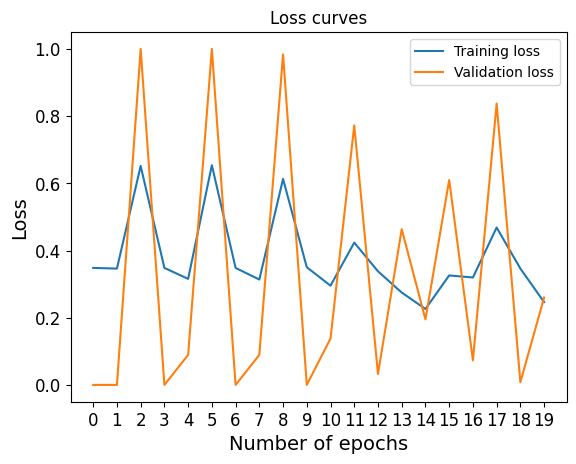

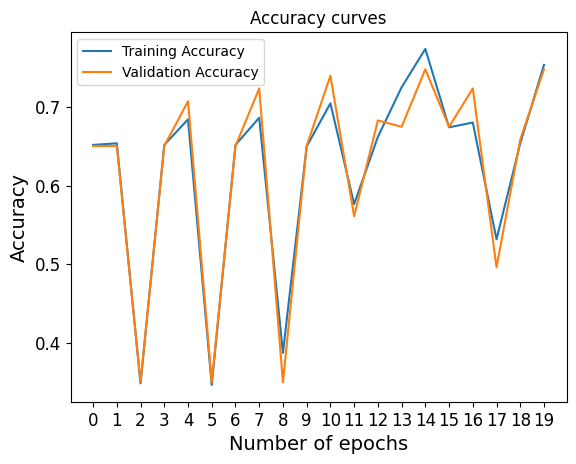

19


In [33]:
# Create a simple perceptron
perceptron = Perceptron(X_train, y_train, X_val, y_val, lr=0.01, bias=True,
                        seed=200, randomBias=True, earlyStoppingPatience=8)
perceptron.train(epochs=20)

# Set best weights
perceptron.setBest()